# Gaussian Process Regression (GPR)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ExpSineSquared, Sum

In [2]:
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = X + np.sin(2*X)

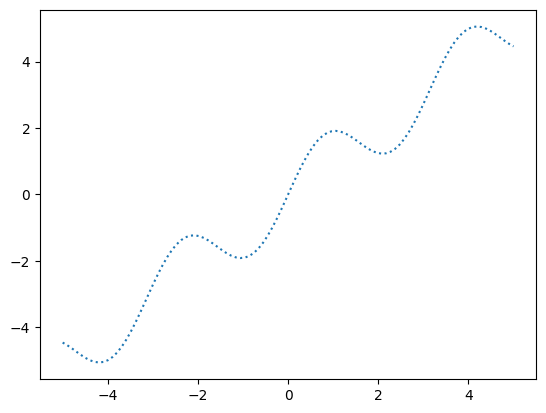

In [3]:
plt.plot(X, y, label=r"$f(x) = x + \sin(x)$", linestyle="dotted")

In [4]:
X_train, _, y_train, _ = train_test_split(
    X, y, test_size=0.9, random_state=59382
)

In [5]:
rbf_gp = GaussianProcessRegressor(kernel=RBF())
rbf_gp.fit(X_train, y_train)

sin_gp = GaussianProcessRegressor(kernel=ExpSineSquared())
sin_gp.fit(X_train, y_train)

lin_gp = GaussianProcessRegressor(kernel=DotProduct())
lin_gp.fit(X_train, y_train)

sin_lin_gp = GaussianProcessRegressor(kernel=Sum(ExpSineSquared(), DotProduct()))
sin_lin_gp.fit(X_train, y_train)

,kernel,ExpSineSquare...uct(sigma_0=1)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,ExpSineSquare...periodicity=1)
,kernel__k2,DotProduct(sigma_0=1)
,kernel__k1__length_scale,1.0


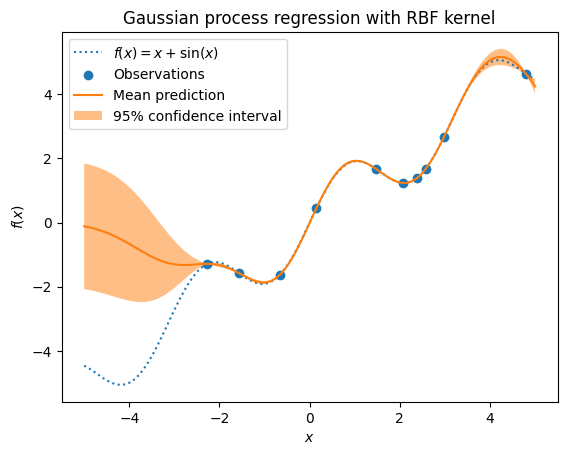

In [6]:
mean_prediction, std_prediction = rbf_gp.predict(X.reshape(-1,1), return_std=True)

plt.plot(X, y, label=r"$f(x) = x + \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression with RBF kernel")

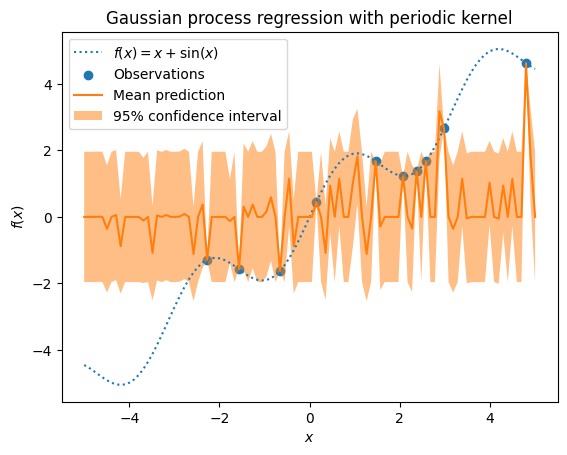

In [7]:
mean_prediction, std_prediction = sin_gp.predict(X.reshape(-1,1), return_std=True)

plt.plot(X, y, label=r"$f(x) = x + \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression with periodic kernel")

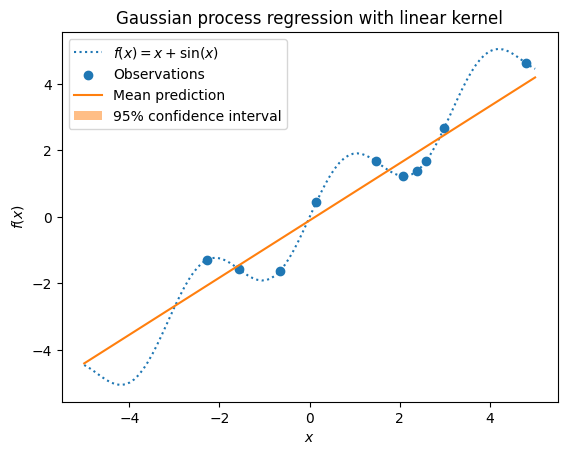

In [8]:
mean_prediction, std_prediction = lin_gp.predict(X.reshape(-1,1), return_std=True)

plt.plot(X, y, label=r"$f(x) = x + \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression with linear kernel")

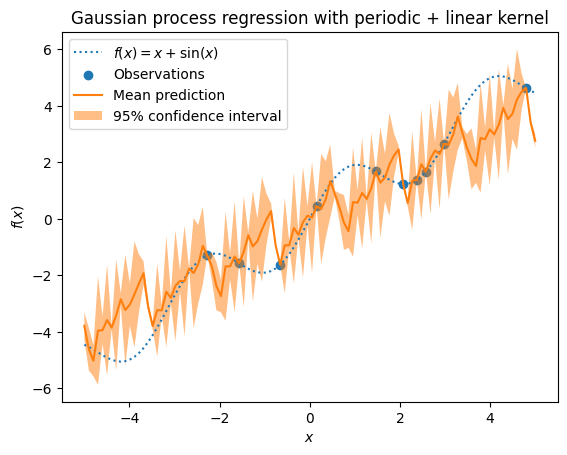

In [9]:
mean_prediction, std_prediction = sin_lin_gp.predict(X.reshape(-1,1), return_std=True)

plt.plot(X, y, label=r"$f(x) = x + \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression with periodic + linear kernel")